# ЛР №1. Налаштування оточення розробки. Знайомство з фреймворком PyTorch.

Імпорт залежностей

In [1]:
import torch
import random
import numpy as np

from src.definitions import EXTERNAL_DATA_FOLDER, MODELS_FOLDER
from src.visualization.image import sample_image_dataset
from src.visualization.plot import plot_loss_and_val_loss, plot_loss_and_val_accuracy
from src.model.breed_classification.oxford_pet import OxfordPet
from src.data.util.dataset import get_mean_std

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from sklearn.model_selection import train_test_split

## Виконання роботи

1. Виконати налаштування робочої середи;
2. Встановити сід генератору псевдовипадкових чисел;

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

3. Завантажити обраний набір даних;

In [3]:
original_trans = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

original_train_ds = OxfordIIITPet(
    EXTERNAL_DATA_FOLDER, download=True, transform=original_trans
)

original_train_loader = DataLoader(original_train_ds, batch_size=32)

mean, std = get_mean_std(original_train_loader)

print("Dataset mean: " + str(mean.tolist()))
print("Dataset std: " + str(std.tolist()))

Dataset mean: [0.4782867431640625, 0.44586294889450073, 0.39569270610809326]
Dataset std: [0.2600521445274353, 0.2547566592693329, 0.2626991868019104]


In [4]:
trans = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

complete_train_ds = OxfordIIITPet(EXTERNAL_DATA_FOLDER, download=True, transform=trans)
test_ds = OxfordIIITPet(EXTERNAL_DATA_FOLDER, split="test", transform=trans)

4. Відобразити декілька зображень з набору даних у блокноті;

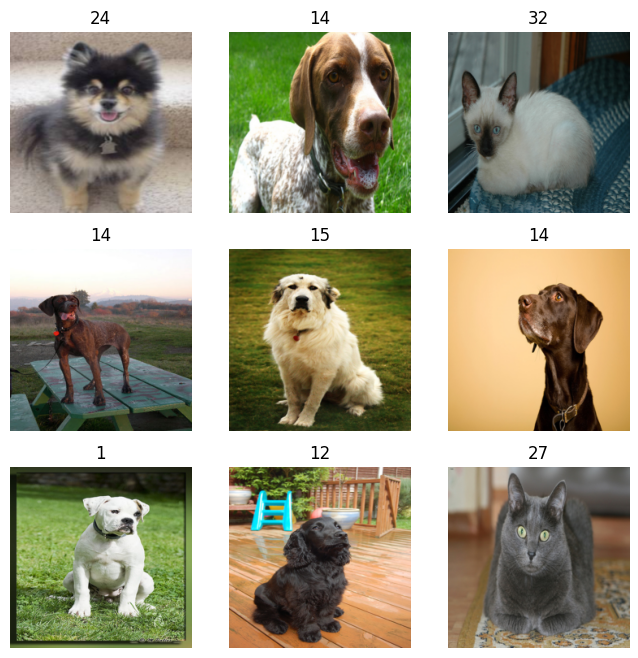

In [5]:
sample_image_dataset(original_train_ds)

5. Розділити обраний набір даних на три вибірки: тренувальну, валідаційну та тестову. Співвідношення розміру вибірок обрати на власний розсуд;

In [6]:
batch_size = 32

train_ds, valid_ds = train_test_split(
    complete_train_ds, train_size=0.9, random_state=random_seed
)

train_loader = DataLoader(train_ds, batch_size=batch_size)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Train dataset size: " + str(len(train_ds)))
print("Validation dataset size: " + str(len(valid_ds)))
print("Test dataset size: " + str(len(test_ds)))

Train dataset size: 3312
Validation dataset size: 368
Test dataset size: 3669


6. Завантажити та налаштувати нейронну мережу обраної архітектури;

In [7]:
model = OxfordPet(device)

loss_fun = CrossEntropyLoss()
optimizer = Adam(model.parameters())

model.eval()

OxfordPet(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

7. Провести навчання нейронної мережі. Вибір гіперпараметрів на власний розсуд;

In [8]:
feedback = model.fit(
    num_epochs=5,
    train_loader=train_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun,
    optimizer=optimizer,
)


Overall progress:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

In [9]:
test_loss, test_accuracy = model.test(loss_fun, test_loader)

print("Accuracy of the network on test images: %s %%" % test_accuracy)
print("Loss of the network on test images: %s %%" % test_loss)

Accuracy of the network on test images: 0.8252717391304348 %
Loss of the network on test images: 0.6326425406814846 %


8. Зберегти ваги навченої нейронної мережі у файл. 

In [12]:
MODELS_FOLDER.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), MODELS_FOLDER / "VGG-oxford-iiit-pet.pickle")

9. Побудувати графіки точності та loss мережі під час навчання. Зробити висновки, оформити звіт;

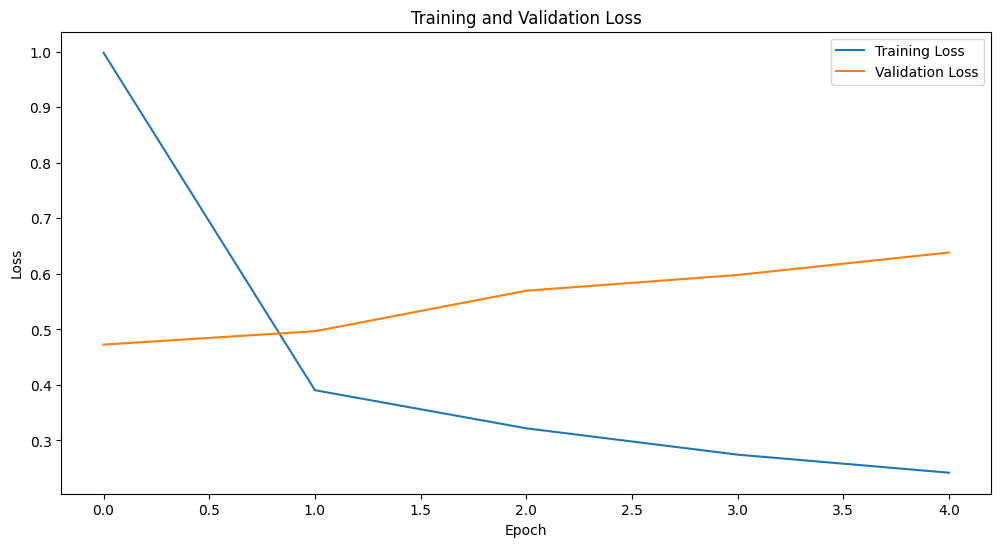

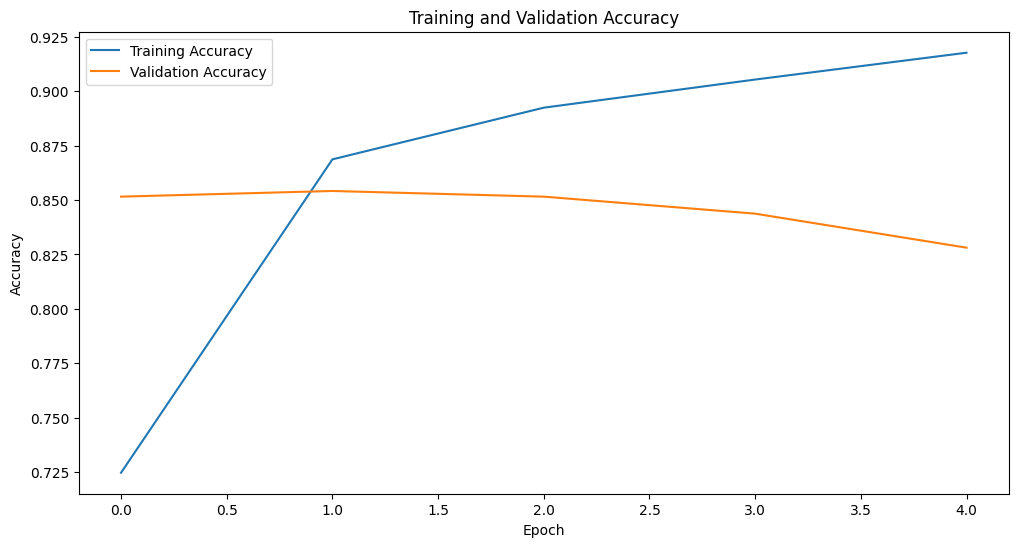

In [13]:
plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)